In [5]:
!python download.py physio

100% [......................................................] 6632372 / 6632372

In [34]:
!python exe_physio.py --gp_noise --modelfolder physio_fold0_20250108_170745

the folder is:  /home/gsasseville/Files/UDEM/Maitrise/SgrA/SgrA_Interpolation/Diffusion/data
Namespace(config='base.yaml', device='cuda:0', seed=1, testmissingratio=0.1, nfold=0, unconditional=False, gp_noise=True, modelfolder='physio_fold0_20250108_170745', nsample=100)
{
    "train": {
        "epochs": 50,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.1
    }
}
/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because enc

/tmp/ipykernel_27788/2018776473.py:70: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


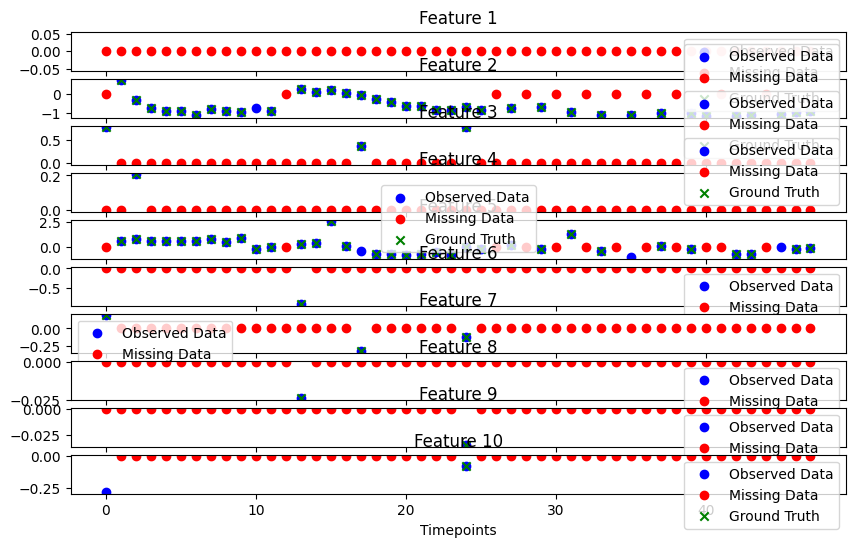

In [4]:
import matplotlib.pyplot as plt

from dataset_physio import get_dataloader

# Step 1: Load the data
seed = 1
nfold = 0  # Select a fold for cross-validation
batch_size = 16
missing_ratio = 0.1

train_loader, valid_loader, test_loader = get_dataloader(
    seed=seed, nfold=nfold, batch_size=batch_size, missing_ratio=missing_ratio
)

# Step 2: Extract the first batch and sample
for batch in train_loader:
    sample = {
        "observed_data": batch["observed_data"][0].numpy(),  # First sample in batch
        "observed_mask": batch["observed_mask"][0].numpy(),
        "gt_mask": batch["gt_mask"][0].numpy(),
        "timepoints": batch["timepoints"][0].numpy(),
    }
    break  # Stop after first batch

# Step 3: Plot the data
observed_data = sample["observed_data"]
observed_mask = sample["observed_mask"]
gt_mask = sample["gt_mask"]
timepoints = sample["timepoints"]

num_features = min(10, observed_data.shape[1])  # Limit to 4 features
fig, axes = plt.subplots(num_features, 1, figsize=(10, 6), sharex=True)

for i in range(num_features):
    ax = axes[i]
    
    # Observed values
    obs_indices = observed_mask[:, i] == 1
    ax.scatter(
        timepoints[obs_indices],
        observed_data[obs_indices, i],
        label="Observed Data",
        color="blue",
    )
    
    # Missing values
    missing_indices = observed_mask[:, i] == 0
    ax.scatter(
        timepoints[missing_indices],
        observed_data[missing_indices, i],
        label="Missing Data",
        color="red",
    )
    
    # Ground truth mask (if relevant for the plot)
    if gt_mask is not None:
        gt_indices = gt_mask[:, i] == 1
        ax.scatter(
            timepoints[gt_indices],
            observed_data[gt_indices, i],
            label="Ground Truth",
            color="green",
            marker="x",
        )
    
    ax.set_title(f"Feature {i + 1}")
    ax.legend()

plt.xlabel("Timepoints")
plt.tight_layout()
plt.show()


In [1]:
!python exe_sgra.py --gp_noise --modelfolder sgra_fold0_20250113_114257 #sgra_fold0_20241216_104917

Namespace(config='base.yaml', device='cuda:0', seed=1, testmissingratio=0.1, nfold=0, unconditional=False, gp_noise=True, modelfolder='sgra_fold0_20250113_114257', nsample=100)
{
    "train": {
        "epochs": 4,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.1
    }
}
/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


In [21]:
import torch
import numpy as np
feature_idx = 0
samples_median = torch.ones((2, 100, 4, 2)).median(dim=1)
predicted_means = samples_median.values

# [eval_mask[:, feature_idx].bool(), feature_idx]

c_target = torch.from_numpy(np.array([[[0., 2.],
         [0., 1.],
         [0., 1.],
         [0., 0.]],

        [[0., 1.],
         [0., 0.],
         [0., 0.],
         [0., 1.]]]))

eval_points = torch.from_numpy(np.array([[[1., 1.],
         [1., 1.],
         [1., 0.],
         [1., 1.]],

        [[0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 1.]]]))

eval_targets = c_target[eval_points[:, :, feature_idx].bool()]
eval_preds = predicted_means[eval_points[:, :, feature_idx].bool()]

print(eval_targets)
print(eval_preds)
# print('Predicted means: ', c_target[eval_points[:, :, feature_idx].bool()])
# print(c_target.shape)
# print(eval_points[:, :, feature_idx].bool())
# print(c_target[:, :, feature_idx])

# feature_target = c_target[:, :, feature_idx]

# print(feature_target)

# c_target[eval_points[:, feature_idx].bool(), feature_idx]
# # torch.sum(tmp).item()
# print(samples_median)
# print(c_target)
# print(eval_points)

# tmp_mse = (((samples_median.values - c_target) * eval_points) ** 2).sum().item()
# tmp_eval_points = eval_points.sum().item()

# print(tmp_mse)
# print(tmp_eval_points)
# print(tmp_mse/tmp_eval_points)


# arr1 = torch.ones(4)
# arr2 = torch.zeros(4)
# arr3 = torch.ones(4) * 2

# arrays = []
# arrays.append(arr1)
# arrays.append(arr2)
# arrays.append(arr3)
# print(np.mean(arrays, axis=0))

tensor([[0., 2.],
        [0., 1.],
        [0., 1.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


In [6]:
import numpy as np
def compute_mse_per_feature(predicted_means, c_target, eval_points):
    """
    Compute the MSE per feature and the total average MSE.

    Args:
        predicted_means (torch.Tensor): Predicted means of shape (B, L, K).
        c_target (torch.Tensor): Target values of shape (B, L, K).
        eval_points (torch.Tensor): Mask of shape (B, L, K) with 1 for validation points and 0 otherwise.

    Returns:
        mse_per_feature (torch.Tensor): MSE per feature (shape: K).
        total_average_mse (float): Total average MSE across all features.
    """
    # Compute the squared errors
    squared_errors = ((predicted_means - c_target) ** 2) * eval_points

    # Sum over batch (B) and timesteps (L) dimensions for each feature
    total_squared_error_per_feature = squared_errors.sum(dim=(0, 1))

    # Count the number of valid points for each feature
    total_eval_points_per_feature = eval_points.sum(dim=(0, 1))

    # Compute the MSE per feature
    mse_per_feature = total_squared_error_per_feature / total_eval_points_per_feature

    # Compute the total average MSE across all features
    total_average_mse = mse_per_feature.mean().item()

    return mse_per_feature, total_average_mse


import torch

# Example data
B, L, K = 2, 4, 2
# predicted_means = torch.rand(B, L, K)  # Predicted means
# c_target = torch.rand(B, L, K)         # Target values
# eval_points = torch.randint(0, 2, (B, L, K))  # Random mask (0 or 1)

samples_median = torch.ones((2, 100, 4, 2)).median(dim=1)
predicted_means = samples_median.values
c_target = torch.from_numpy(np.array([[[0., 2.],
         [-1., 1.],
         [0., 1.],
         [0., 0.]],

        [[0., 1.],
         [0., 0.],
         [0., 0.],
         [0., 1.]]]))

eval_points = torch.from_numpy(np.array([[[1., 1.],
         [1., 1.],
         [1., 0.],
         [1., 1.]],

        [[0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 1.]]]))

# Compute MSE per feature and total average MSE
mse_per_feature, total_average_mse = compute_mse_per_feature(predicted_means, c_target, eval_points)

print("MSE per feature:", mse_per_feature)
print("Total average MSE:", total_average_mse)

(
                    ((samples_median.values - c_target) * eval_points) ** 2
                ).sum().item() / eval_points.sum().item()

MSE per feature: tensor([1.6000, 0.5000], dtype=torch.float64)
Total average MSE: 1.05


1.1111111111111112

In [4]:
!python exe_sgra.py --gp_noise --modelfolder sgra_fold0_20250118_103658

Namespace(config='base.yaml', device='cuda:0', seed=1, testmissingratio=0.1, nfold=0, unconditional=False, gp_noise=True, modelfolder='sgra_fold0_20250118_103658', nsample=100)
{
    "train": {
        "epochs": 5,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.1
    }
}
/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


In [28]:
!python exe_sgra.py --gp_noise --modelfolder sgra_fold0_20250113_114257 #sgra_fold0_20241216_104917

Namespace(config='base.yaml', device='cuda:0', seed=1, testmissingratio=0.1, nfold=0, unconditional=False, gp_noise=True, modelfolder='sgra_fold0_20250113_114257', nsample=100)
{
    "train": {
        "epochs": 4,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.1
    }
}
/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


In [11]:
!python exe_sgra.py --gp_noise --modelfolder sgra_fold0_20250113_114257 #sgra_fold0_20241216_104917

Namespace(config='base.yaml', device='cuda:0', seed=1, testmissingratio=0.1, nfold=0, unconditional=False, gp_noise=True, modelfolder='sgra_fold0_20250113_114257', nsample=100)
{
    "train": {
        "epochs": 4,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.1
    }
}
/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


In [10]:
!python exe_walk.py --gp_noise --modelfolder walk_fold0_20250109_173144

Namespace(config='base.yaml', device='cuda:0', seed=1, testmissingratio=0.1, nfold=0, unconditional=False, gp_noise=True, modelfolder='walk_fold0_20250109_173144', nsample=100)
{
    "train": {
        "epochs": 4,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.1
    }
}
/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


In [26]:
import torch
checkpoint = torch.load('save/walk_fold0_20250109_173144/' + "model.pth")

/tmp/ipykernel_7031/1216537216.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('save/walk_fold0_20250109_173144/' + "model.pth")


In [27]:
checkpoint['metrics']

{'train': {'loss': [0.05275875555921346,
   0.022841681021526457,
   0.01855702008485794,
   0.016880003241412343]},
 'val': {'loss': [0.016394420284408448, 0.016158094078478756]}}